# comparingTailLengths.ipynb
## Marcus Viscardi,    January 16, 2023

General goal to just look at the tail length distibutions of a couple genes.

I think *odc-1* is of particular interest b/c it has only one isoform, but that one isoform looks NMD sensitive! This would mean that all the reads mapping are likely relevant to NMD. The counter-example would be a gene like *ubl-1* in which ~most of the reads are not related to NMD, and I have no good way to parse out which are which.

**update 1/17/23:** So we seem to have a problem with the really low number of adapted reads for basically all genes, even in N2 libraries. The two pilot libs seem to have way better depth and adapted species coverage... For example. In my newN2 lib, *odc-1* only has **4** adapted reads!

In [2]:
import os
import sys
sys.path.insert(0, '/data16/marcus/scripts/nanoporePipelineScripts')
import nanoporePipelineCommon as npCommon

import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "browser"

print(f"Imports done at {npCommon.get_dt(for_print=True)}")

Imports done at 03/02/23 @ 12:55:43 PM


In [3]:
try:
    reads_df_genes = pd.read_parquet(npCommon.find_newest_matching_file(f"./output_files/*_quad5TERA.reads_df.parquet"))
    compressed_df_genes = pd.read_parquet(npCommon.find_newest_matching_file(f"./output_files/*_quad5TERA.compressed_df.parquet"))
    conversion_dict = {"xrn-1-5tera": "oldN2",
                       "xrn-1-5tera-smg-6": "oldS6",
                       "5tera_xrn-1-KD_wt": "newN2",
                       "5tera_xrn-1-KD_smg-5": "newS5",
                       "5tera_xrn-1-KD_smg-6": "newS6",
                       "5tera_xrn-1-KD_smg-7": "newS7",
                       }
    reads_df_genes.replace(conversion_dict, inplace=True)
    compressed_df_genes.replace(conversion_dict, inplace=True)
    print(f"Finished library loading at {npCommon.get_dt(for_print=True)}")
except ValueError:
    reads_df_genes, compressed_df_genes = None, None
    print("Could not find pre-compressed dataframes saved. Try running the first few cells of initialTestingAndScratchPaper.ipynb")

Finished library loading at 03/02/23 @ 12:55:58 PM


In [4]:
compressed_df_genes.query("gene_name == 'ets-4'")[["lib", 'gene_id', 'gene_name', 't5', 'gene_hits', 'mean_polya_length', 'median_polya_length']]

,lib,gene_id,gene_name,t5,gene_hits,mean_polya_length,median_polya_length
59147,sPM57,WBGene00017687,ets-4,-,3,128.20,128.20
59148,sPM57,WBGene00017687,ets-4,+,1,53.08,53.08
73982,sPM58,WBGene00017687,ets-4,-,1,52.92,52.92


In [4]:
target_gene = 'F19B2.5'

for lib in ['oldN2', 'newN2', 'newS5']:
    plot_df = reads_df_genes.query(f"gene_name == '{target_gene}'").query(f"lib == '{lib}'")
    
    fig = px.ecdf(plot_df,
                  color='t5',
                  x='polya_length',
                  ecdfnorm='percent',
                  marginal="rug")
    fig.update_layout(title=f"{target_gene} for {lib}")
    fig.show()

/tmp/ipykernel_2405319/1327743319.py:24: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



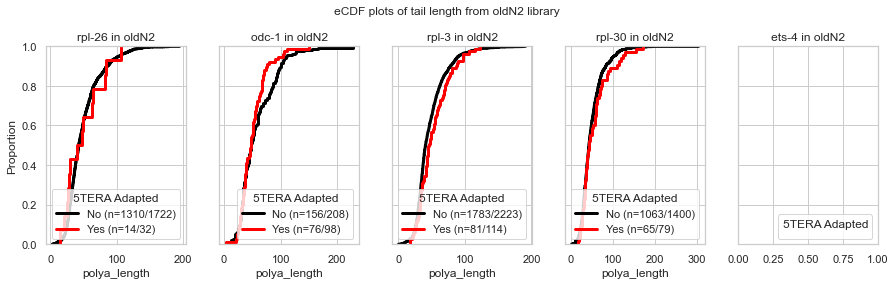

/tmp/ipykernel_2405319/1327743319.py:24: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



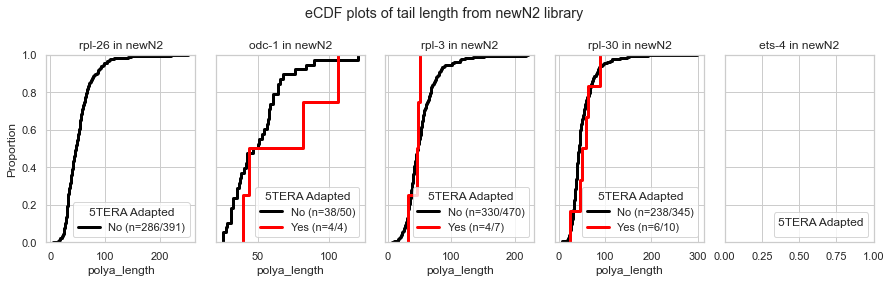

In [7]:
# target_genes = ['odc-1', 'F19B2.5', 'rpl-3', 'rpl-7A', 'rpl-30', 'ubl-1', 'nduo-5']
# target_genes = ['rpl-7A', 'rpl-12', 'rpl-1', 'rpl-3']
target_genes = ['rpl-26', 'odc-1', 'rpl-3', 'rpl-30', 'ets-4']
target_libs = [
    'oldN2',
    'newN2',
    #'newS5',
    #'newS6',
    #'oldS6',
]

for lib in target_libs:
    plot_df = reads_df_genes.query(f"lib == '{lib}'")
    sea.set()
    sea.set_style("whitegrid")
    fig, axes = plt.subplots(1, len(target_genes), figsize=(2.5*len(target_genes), 4),
                             sharey='all',
                             #sharex='all',
                             )
    fig.suptitle(f"eCDF plots of tail length from {lib} library")
    
    for i, target_gene in enumerate(target_genes):
        subplot_df = plot_df.query(f"gene_name == '{target_gene}'")
        sea.ecdfplot(ax=axes[i],
                     data=subplot_df,
                     x='polya_length',
                     hue='t5',
                     palette={'-': 'black',
                              '+': 'red'},
                     linewidth=3)
        axes[i].set_title(f"{target_gene} in {lib}")
        axes[i].legend(title=f"5TERA Adapted",
                       loc="lower right",
                       labels=[f"No (n={subplot_df[subplot_df.t5 == '-'].count()['polya_length']}/{subplot_df[subplot_df.t5 == '-'].count()['lib']})", f"Yes (n={subplot_df[subplot_df.t5 == '+'].count()['polya_length']}/{subplot_df[subplot_df.t5 == '+'].count()['lib']})"])
    plt.tight_layout()
    save_path = f"./output_files/tail_lengths/{npCommon.get_dt()}_tailLengthCDFs_{lib}"
    for file_type in ['.svg', '.png']:
        plt.savefig(save_path + file_type,
                    dpi=300)
    plt.show()

<AxesSubplot: label='left'>

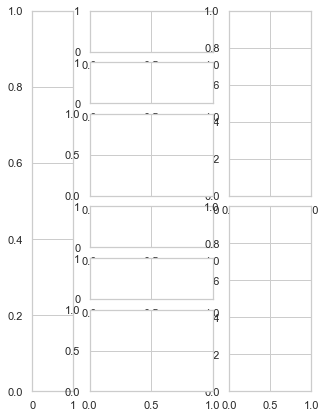

In [10]:
# See sticky note above my bench...

gs_kw = dict(width_ratios=[1, 3, 2], height_ratios=[1, 1, 2, 1, 1, 2,])

fig, axdict = plt.subplot_mosaic([['left', 'upper top', 'upper right'],
                                  ['left', 'upper middle', 'upper right'],
                                  ['left', 'upper bottom', 'upper right'],
                                  ['left', 'lower top', 'lower right'],
                                  ['left', 'lower middle', 'lower right'],
                                  ['left', 'lower bottom', 'lower right'],
                                 ],
                                 gridspec_kw=gs_kw,
                                 # constrained_layout=True,
                                 figsize=(5, 7),
                                 )
axdict['left']
# plt.tight_layout()

In [11]:
isinstance(axdict, plt.Axes)

False

In [9]:
plot_df.query("gene_name == 'ets-4'")

,lib,read_id,chr_id,chr_pos,original_chr_pos,gene_id,gene_name,cigar,sequence,polya_length,strand,t5,read_length


In [14]:
reads_df_genes.query("gene_name == 'ets-4'")

,lib,read_id,chr_id,chr_pos,original_chr_pos,gene_id,gene_name,cigar,sequence,polya_length,strand,t5,read_length
2207000,sPM57,15c8cac6-0485-4b3e-9d44-c7d04d3754de,X,6518935,6518935,WBGene00017687,ets-4,29M1D9M2I74M59N13M2I37M2I4M1I3M1I2M1I13M53N2M1...,TCTAGTGCACAAACAGGTCGACACTACTCTCGGTCGTGATACTTAA...,NaN,+,-,2026
2207002,sPM57,f2175614-101c-43ea-8b66-6257f4cf6738,X,6521523,6521523,WBGene00017687,ets-4,16M1I37M1I3M2D25M1I13M2I33M1I28M1D23M4D10M1D9M...,TTGACGCAATGTGCAACCGGAAGCGAGGGAGATGACGATGAGCGTG...,53.08,+,+,684
2207003,sPM57,cfe8e1bd-c3fb-41bd-8f48-69446410faca,X,6522024,6522024,WBGene00017687,ets-4,1S5M2D10M1D18M1I11M11D4M2D3M2D7M1I20M1D10M1D2M...,TTGTGACAAGATATACTCCACGTACTGTTCGTTGAAAGAACATATT...,NaN,+,-,482
2207004,sPM57,6921c0fa-cd01-4005-9a31-f4688ee1a5fa,X,6522030,6522030,WBGene00017687,ets-4,2S21M2I37M1I26M2I16M1D7M1D12M2D88M1I31M1D29M1D...,GATCAAGATATACTTCCATGTACTGTGTTCGTTGTAGAACATATTC...,128.20,+,-,477
2859758,sPM58,82e931b1-a79c-4258-bc41-046e5f4b110b,X,6520658,6520658,WBGene00017687,ets-4,73M1D46M2D4M1I12M1D19M2I16M131N26M5D8M1D14M1D1...,CCGAGCATGGAGCACGATGGATCAACGAGATGTGCATGCAATTCAA...,52.92,+,-,359
